# Overview of Neural Networks with Numpy

In [52]:
## Package imports
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D
import numpy as np
import sklearn
import sklearn.datasets
import sklearn.linear_model
import matplotlib

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)

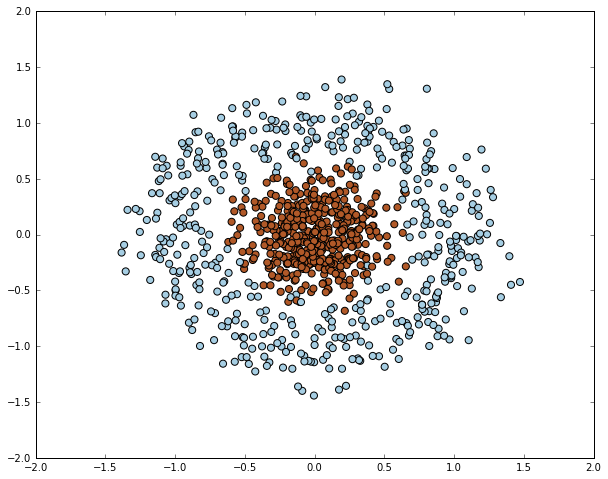

In [2]:
## Generate non-separable data.
data, labels = sklearn.datasets.make_circles(1000, noise=0.20, factor=0.2)
plt.scatter(data[:,0], data[:,1], s=50, c=labels, cmap=plt.cm.Paired)

### Logistic Classification Method

In [3]:
## We start by implementing a logistic (linear) classifier.
logistic = sklearn.linear_model.LogisticRegressionCV()
logistic.fit(data,labels)

LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

In [4]:
def plot_boundary(pred_func):
    ## Copy data.
    X = data.copy()
    y = labels.copy()
    
    # Set min and max values and give it some padding.
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.03
    # Generate a grid of points with distance h between them.
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid.
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples.
    plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)
    plt.scatter(X[:, 0], X[:, 1], s = 50, c=y, cmap=plt.cm.Paired)

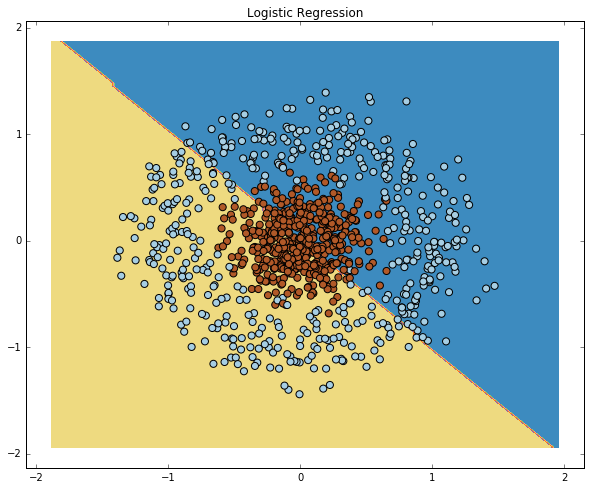

In [5]:
plot_boundary(lambda x: logistic.predict(x))
plt.title("Logistic Regression")

### Neural Network

Logistic regression Does a terrible job in (linearly) classifying the data. Now we try a neural network, which is made up of:

**1)** Two input layers (one for each dimension).
**2)** Two hidden layers.  
**3)** Two output layers (one for each class).

We use a *tanh* activation function for the input layer, and a *softmax* for the output one. Below we see these graphically.

*Input of layer 1*: $ \quad z_1 = xW_1 + b_1 \qquad$ *Output of layer 1*: $ \quad a_1 = tanh(z_1)$

*Input of layer 2*: $ \quad z_2 = a_1W_2 + b_2 \qquad$ *Output of layer 1*: $ \quad a_2 = softmax(z_2) = \hat{y}$

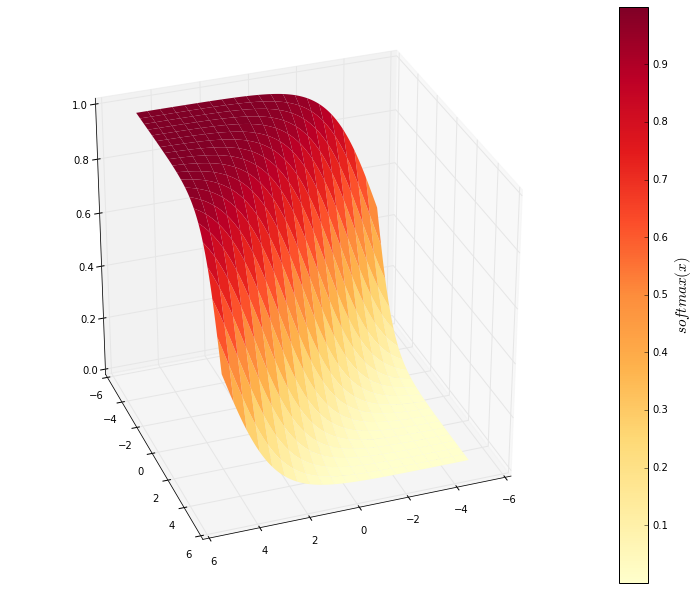

In [89]:
## Softmax
def softmax(x):
    return np.exp(x) / np.sum(np.exp(x))

x = np.linspace(-5, 5, 200)
x_1, x_2 = np.meshgrid(x, x)
y = np.zeros((200, 200, 2))

for i in xrange(len(x)):
    for j in xrange(len(x)):
        y[i,j:] = softmax(np.array([x_1[i,j], x_2[i,j]]))

fig = plt.figure()
ax = Axes3D(fig)
surf = ax.plot_surface(x_1, x_2, y[:,:,0], linewidth=0, cmap=plt.cm.YlOrRd)
ax.view_init(elev=30, azim=70)
cbar = fig.colorbar(surf)
cbar.ax.set_ylabel('$softmax(x)$', fontsize=15)
plt.show()

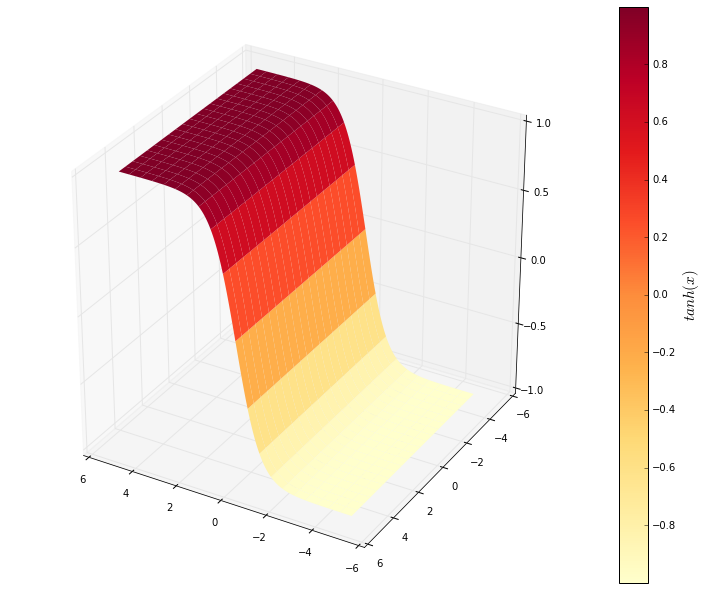

In [90]:
## Tanh
for i in xrange(len(x)):
    for j in xrange(len(x)):
        y[i,j:] = np.tanh(np.array([x_1[i,j], x_2[i,j]]))

fig = plt.figure()
ax = Axes3D(fig)
surf = ax.plot_surface(x_1, x_2, y[:,:,0], linewidth=0, cmap=plt.cm.YlOrRd)
ax.view_init(elev=30, azim=120)
cbar = fig.colorbar(surf)
cbar.ax.set_ylabel('$tanh(x)$', fontsize=15)
plt.show()

The parameters our model needs to learn are then $(W_1, W_2, b_1, b_2)$. For this we will use *cross-entropy loss function*, defined as:

$L(y,\hat{y}) = \sum_N \sum_C y_{n,1} log(\hat{y})_{n,i}$

Where $N$ are the total of observations and $C$ the different classes.

### Implementation

In [8]:
num_examples = len(data)
nn_input_dim = 2
nn_output_dim = 2

In [9]:
## We start by defining the loss function.
def calculate_loss(model, x, y):
    num_batch = len(x)
    
    ## Copy data.
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    ## Forward propagation that goes through the input layers:
    z1 = x.dot(W1) + b1
    a1 = np.tanh(z1)
    z2 = a1.dot(W2) + b2
    exp_scores = np.exp(z2)
    ## Probability:
    probs = exp_scores / np.sum(exp_scores, axis = 1, keepdims=True)
    ## Select logprobs for observations where y=1.
    correct_logprobs = -np.log(probs[range(num_batch), y])
    data_loss = np.sum(correct_logprobs)
    ## Add regularization term (optional).
    data_loss += reg_lambda/2 * (np.sum(np.square(W1)) + np.sum(np.square(W2)))
    return 1./num_examples * data_loss

In [10]:
## We define a predict function that works the same way as defined above.
def predict(model, x): 
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    z1 = x.dot(W1) + b1
    a1 = np.tanh(z1)
    z2 = a1.dot(W2) + b2
    exp_scores = np.exp(z2)
    probs = exp_scores / np.sum(exp_scores, axis = 1, keepdims=True)
    return np.argmax(probs, axis=1)

In [11]:
## Now we build the back-propagation neural network model.
def build_model(nn_hdim, epochs=20000, batch=False, print_loss=False):
    ## Initialize parameters to random.
    np.random.seed(0)
    W1 = np.random.randn(nn_input_dim, nn_hdim) / np.sqrt(nn_input_dim)
    b1 = np.zeros((1, nn_hdim))
    W2 = np.random.randn(nn_hdim, nn_output_dim) / np.sqrt(nn_hdim)
    b2 = np.zeros((1, nn_output_dim))
    
    model = {}
    X = data.copy()
    y = labels.copy()
    num_batch = len(X)
    
    ## Gradient descent.
    
    for i in xrange(0, epochs):
        
        ## Get random sample in the case of BGD.
        if batch:
            index = np.random.choice(num_examples, 256)
            X = data[index].copy()
            y = labels[index].copy()
            num_batch = len(index)
        
        ## Forward propagation.
        z1 = X.dot(W1) + b1
        a1 = np.tanh(z1)
        z2 = a1.dot(W2) + b2
        exp_scores = np.exp(z2)
        probs = exp_scores / np.sum(exp_scores, axis = 1, keepdims = True)
        
        ## Backward propagation.
        delta3 = probs
        delta3[range(num_batch), y] -= 1
        dW2 = (a1.T).dot(delta3)
        db2 = np.sum(delta3, axis = 0, keepdims = True)
        delta2 = delta3.dot(W2.T) * (1 - np.power(a1, 2))
        dW1 = (X.T).dot(delta2)
        db1 = np.sum(delta2, axis = 0)
        
        ## Add regularization.
        dW2 += reg_lambda * W2
        dW1 += reg_lambda * W1
        
        ## Update parameters.
        W1 += -epsilon * dW1 
        b1 += -epsilon * db1
        W2 += -epsilon * dW2
        b2 += -epsilon * db2
        
        model = { 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}
        
        ## Print loss on current stage.
        if print_loss and i % 1000 == 0:
            print "Training loss at epoch %i is %f." %(i, calculate_loss(model, X, y)) 
        
    return model

Training loss at epoch 0 is 0.173785.
Training loss at epoch 1000 is 0.028909.
Training loss at epoch 2000 is 0.021854.
Training loss at epoch 3000 is 0.025724.
Training loss at epoch 4000 is 0.014891.
Training loss at epoch 5000 is 0.015715.
Training loss at epoch 6000 is 0.030214.
Training loss at epoch 7000 is 0.029355.
Training loss at epoch 8000 is 0.024027.
Training loss at epoch 9000 is 0.026013.
Training loss at epoch 10000 is 0.025069.
Training loss at epoch 11000 is 0.024449.
Training loss at epoch 12000 is 0.020511.
Training loss at epoch 13000 is 0.016904.
Training loss at epoch 14000 is 0.016052.
Training loss at epoch 15000 is 0.031799.
Training loss at epoch 16000 is 0.023822.
Training loss at epoch 17000 is 0.073860.
Training loss at epoch 18000 is 0.026539.
Training loss at epoch 19000 is 0.020183.


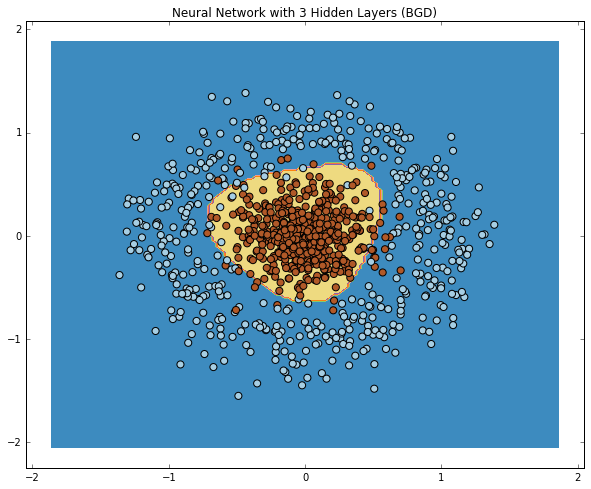

In [12]:
## Estimate model.
epsilon = 0.01
reg_lambda = 0.01 
model = build_model(3, batch = True, print_loss = True)
plot_boundary(lambda x: predict(model, x))
plt.title("Neural Network with 3 Hidden Layers (BGD)")

### Implementation with different number of layers.

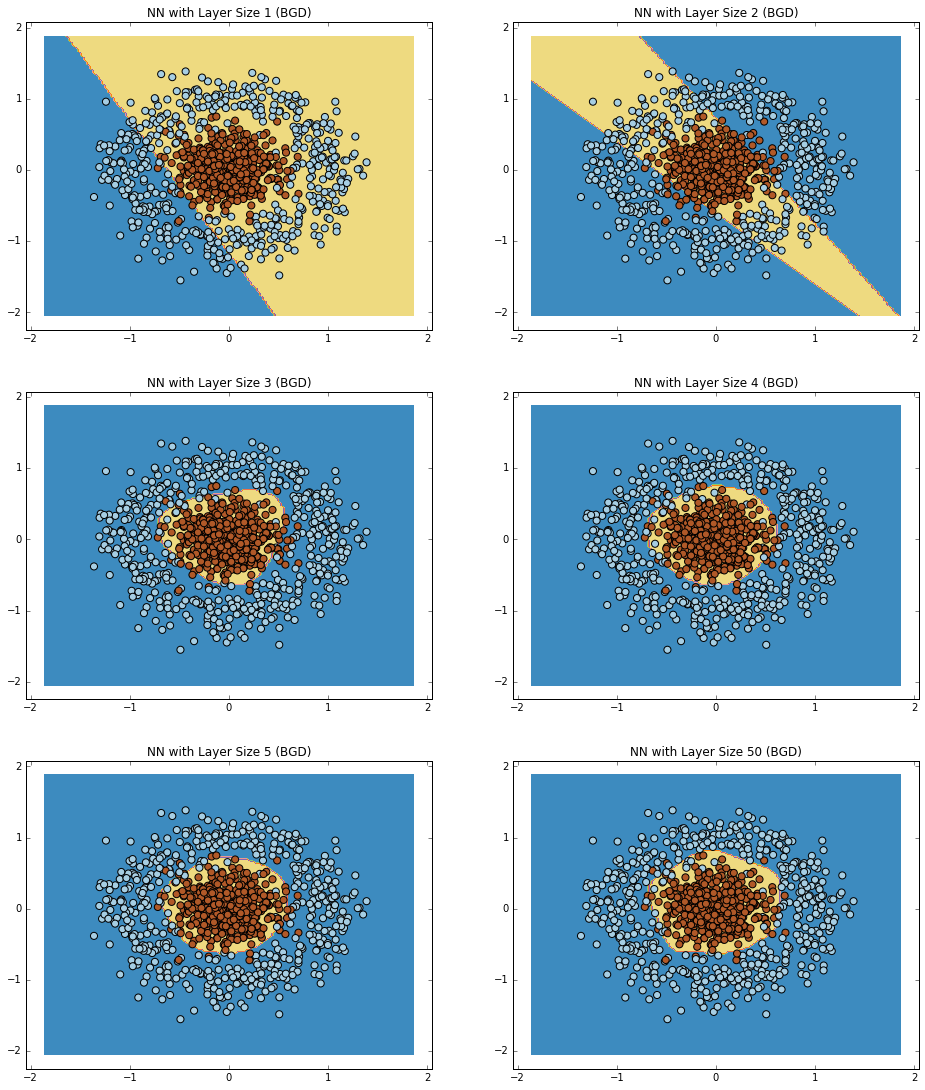

In [15]:
plt.figure(figsize=(16,32))
hidden_layer_dims = [1, 2, 3, 4, 5, 50]

for i, nn_hdim in enumerate(hidden_layer_dims):
    plt.subplot(5,2,i+1)
    plt.title("NN with Layer Size %d (BGD)" % nn_hdim)
    model = build_model(nn_hdim, batch = True)
    plot_boundary(lambda x: predict(model, x))

plt.show()